Hello

In [1]:

import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import copy
import cv2
from queue import PriorityQueue
from typing import List, Tuple, Dict, Set, Final, Hashable

In [2]:
def arr(*l):
    return np.array(l)


INF = int(1e9)

class CacRegion:
    def __init__(self, ccw, color):
        self.ccw_pts_id = ccw
        self.color = color

In [3]:
"""
测试时进需要修改本单元格的数据
"""

# [可视化图像宽高]
GLB_H = 240
GLB_W = 160
GLOBAL_MAT = np.zeros((GLB_H, GLB_W), dtype=int)

# [数字颜色对应关系]
CMAP = {-1: 'black', 0: 'grey', 1: 'blue', 2: 'yellow', 3: 'red', 4: 'cyan'}

# [定义所有顶点]
SEG_PTS = [
    [  6,  54], # 0
    [  6,  48],
    [ 18,  48],
    [ 18,  38],
    [ 18,   0],
    [ 96,   0], # 5
    [168,   0],
    [238,   0],
    [238,  94],
    [238, 158],
    [168, 158], # 10
    [ 98, 158],
    [ 98,  94],
    [ 98,  38],
    [ 96,  38],
    [ 94,  38], # 15
    [ 94,  40],
    [ 94, 158],
    [ 58, 158],
    [ 58,  42],
    [ 72,  42], # 20
    [ 72,  40],
    [ 72,  38],
    [ 44,  38],
    [ 44,  60],
    [ 44, 144], # 25
    [ 18, 144],
    [ 18,  60],
    [  6,  60],
    [168,  94],
]
SEG_PTS = [np.array(x) for x in SEG_PTS]

# [约定]：指定前几个作为房间边缘，剩下点是不在边缘上的点
SEG_WALL_PT_NUM = len(SEG_PTS) - 1

"""
指定各个区域的边界点
[所有区域无交，必须将房间全覆盖]
[必须按逆时针给出]
方式：CacRegion([点1, 点2, ..., 点n], 颜色)
"""
CAC_REGIONS_FAKE = [
    CacRegion([27, 28, 0, 1, 2], 0),
    CacRegion([24, 27, 2, 3, 23], 0),
    CacRegion([23, 3, 4, 5, 14, 15, 16, 21, 22], 0),
    CacRegion([25, 26, 27, 24], 4),
    CacRegion([16, 17, 18, 19, 20, 21], 4),
    CacRegion([29, 12, 13, 14, 5, 6], 4),
    CacRegion([10, 11, 12, 29], 3),
    CacRegion([9, 10, 29, 8], 1),
    CacRegion([8, 29, 6, 7], 2),
]
# 分水器所在区域编号
DESTINATION_PT = 0

SUGGESTED_M0_PIPE_INTERVAL = 4.5

30 29


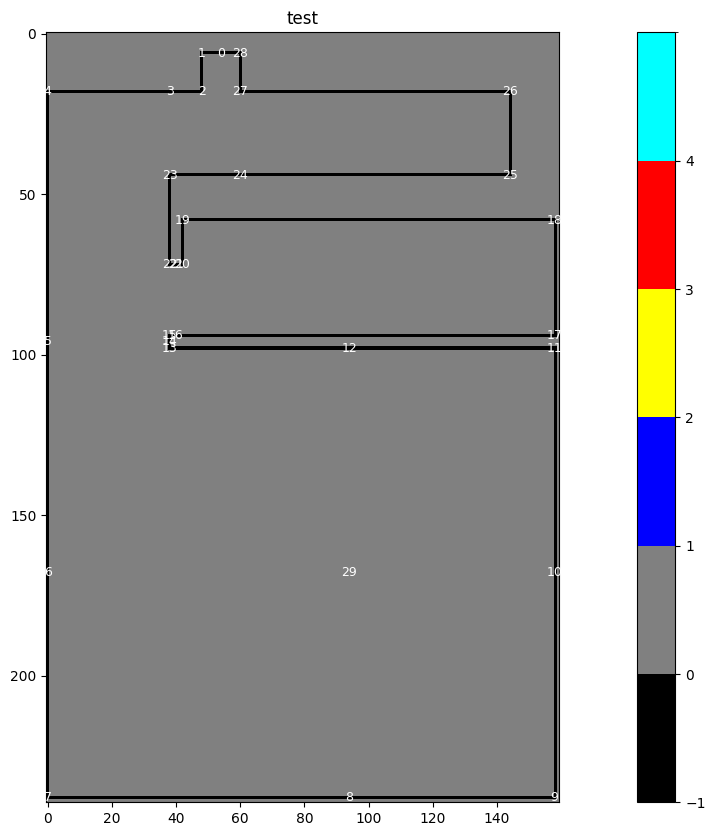

In [ ]:
G0_PIPE_WIDTH = SUGGESTED_M0_PIPE_INTERVAL * 2.0

def seg_pts(pts: list, close=False):
    z = zip(pts, pts[1:] + [pts[0]]) if close else zip(pts[:-1], pts[1:])
    blacks = []
    lx, ly = -1, -1
    for pt, nt in z:
        cnt = int(np.ceil(max(abs(pt[0] - nt[0]), abs(pt[1] - nt[1]))))
        for i in range(cnt + 1):
            x = int(np.round(pt[0] + (nt[0] - pt[0]) * i / cnt))
            y = int(np.round(pt[1] + (nt[1] - pt[1]) * i / cnt))
            if (x, y) != (lx, ly):
                lx, ly = x, y
                blacks.append((x, y))
    return blacks


print(len(SEG_PTS), SEG_WALL_PT_NUM)
BLACKS = seg_pts(SEG_PTS[:SEG_WALL_PT_NUM], close=True)
for x, y in BLACKS:
    GLOBAL_MAT[x, y] = -1


def plot_matrix(matrix, title=None):
    cmap_list = [CMAP[key] for key in sorted(CMAP.keys())]
    custom_cmap = mcolors.ListedColormap(cmap_list)
    bounds = list(CMAP.keys()) + [max(CMAP.keys()) + 1]
    norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)
    if title is not None:
        plt.title(title)
    plt.imshow(matrix, cmap=custom_cmap, norm=norm)
    plt.colorbar(ticks=sorted(CMAP.keys()))


def plot_num(nums):
    for idx, (x, y) in enumerate(nums):
        plt.text(y, x, str(idx), color='white', fontsize=9, ha='center', va='center')   

plt.figure(figsize=(20, 10))  # 设置图像大小为 12x7
plot_matrix(GLOBAL_MAT, title='test')
plot_num(SEG_PTS)
plt.show()

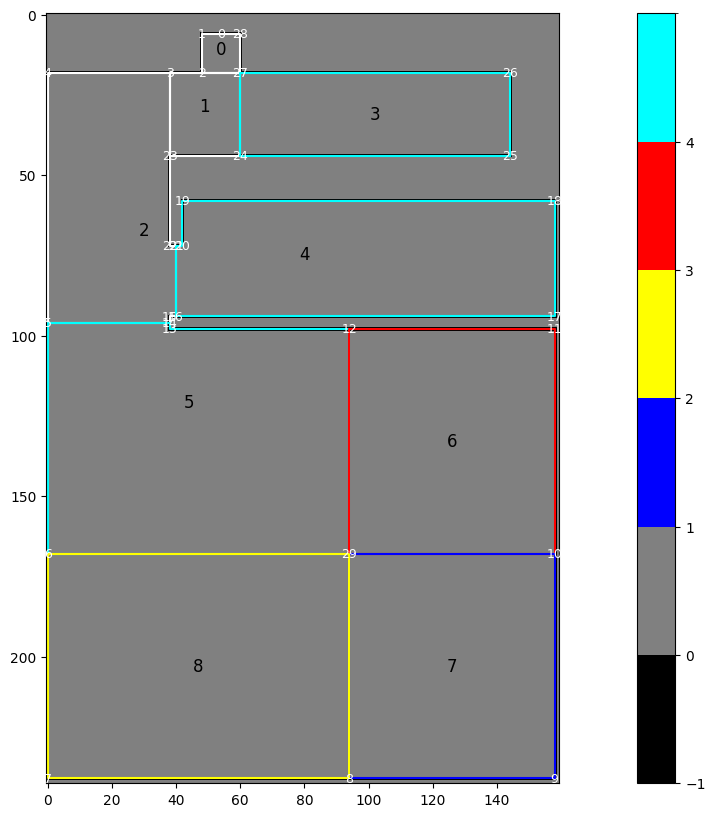

In [5]:
def plot_regions_with_colors(matrix, regions, seg, cmap):
    cmap_list = [cmap[key] for key in sorted(cmap.keys())]
    custom_cmap = mcolors.ListedColormap(cmap_list)
    bounds = list(cmap.keys()) + [max(cmap.keys()) + 1]
    norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)
    
    plt.imshow(matrix, cmap=custom_cmap, norm=norm)
    for idx, region in enumerate(regions):
        x, y = zip(*[seg[i] for i in region.ccw_pts_id])
        x = list(x) + [x[0]]  # 首尾相连
        y = list(y) + [y[0]]  # 首尾相连
        plt.plot(y, x, color=CMAP[region.color] if region.color > 0 else 'white')  # 绘制多边形边缘，颜色为白色
        
        # 计算质心
        centroid_x = sum(x[:-1]) / len(x[:-1])
        centroid_y = sum(y[:-1]) / len(y[:-1])
        plt.text(centroid_y, centroid_x, str(idx), color='black', fontsize=12, ha='center', va='center')  # 显示编号
    
    plt.colorbar(ticks=sorted(cmap.keys()))

plt.figure(figsize=(20, 10))  # 设置图像大小为 20x10
plot_regions_with_colors(GLOBAL_MAT, CAC_REGIONS_FAKE, SEG_PTS, CMAP)
plot_num(SEG_PTS)
plt.show()


In [6]:
def edge_id(tu) -> Tuple:
    return min(tu), max(tu)

class EdgePipes:
    def __init__(self, pipes=None):
        self.ccw_pipes = pipes if pipes is not None else list()
    
    def insert_pipe(self, x_lt_y, idx, pipe_seg_id):
        self.ccw_pipes.insert(idx if x_lt_y else len(self.ccw_pipes) - idx, pipe_seg_id)
    def get_pipes(self, x_lt_y):
        return self.ccw_pipes if x_lt_y else list(reversed(self.ccw_pipes))

In [7]:
# dijkstra 求各个 Region 反向 dijkstra 顺序
PT_EDGE_TO = [[] for _ in range(len(SEG_PTS))]
for r in CAC_REGIONS_FAKE:
    for x, y in zip(r.ccw_pts_id, r.ccw_pts_id[1:] + [r.ccw_pts_id[0]]):
        PT_EDGE_TO[x].append(y)
        PT_EDGE_TO[y].append(x)
# 每个点的出点按极角排序 -pi ~ pi
for id in range(len(SEG_PTS)):
    # 去重
    PT_EDGE_TO[id] = list(set(PT_EDGE_TO[id]))
    PT_EDGE_TO[id] = sorted(PT_EDGE_TO[id], key=lambda x: np.arctan2(SEG_PTS[x][1] - SEG_PTS[id][1], SEG_PTS[x][0] - SEG_PTS[id][0]))

def pt_dis(pt1, pt2):
    return np.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)

def dijk1(set_pts, dest_pt, pt_to):
    dis = np.ones(len(set_pts), dtype=float) * INF
    q = PriorityQueue()
    q.put((0, dest_pt))
    dis[dest_pt] = 0
    while not q.empty():
        _, pt = q.get()
        for y in pt_to[pt]:
            if dis[y] > dis[pt] + pt_dis(set_pts[pt], set_pts[y]):
                dis[y] = dis[pt] + pt_dis(set_pts[pt], set_pts[y])
                q.put((dis[y], y))
    return dis

PTS_DIS = dijk1(SEG_PTS, DESTINATION_PT, PT_EDGE_TO)

CAC_REGIONS_DIS = [min([PTS_DIS[x] for x in r.ccw_pts_id]) for r in CAC_REGIONS_FAKE]

In [8]:
class DisjointSet:
    def __init__(self):
        self.fa_di = dict()
        ...

    def add(self, *xs):
        for x in xs:
            if x not in self.fa_di:
                self.fa_di[x] = x

    def find(self, x):
        if self.fa_di[x] != x:
            self.fa_di[x] = self.find(self.fa_di[x])
        return self.fa_di[x]

    def mix(self, x, y):
        self.fa_di[self.find(x)] = self.find(y)

    def get_sets_di(self) -> Dict[int, List[int]]:
        """
        anc -> its set
        """
        di = {}
        for x in self.fa_di:
            fx = self.find(x)
            if fx not in di:
                di[fx] = []
            di[fx].append(x)
        return di

    def get_ancestor_di(self):
        return { x: self.find(x) for x in self.fa_di }

# test
def test_disjoint_set():
    ds = DisjointSet()
    ds.add(1)
    ds.add(2)
    assert(ds.find(1) == 1)
    ds.mix(1, 2)
    assert(ds.find(1) == 2)

    print(ds.get_sets_di())

    ds.add(3)
    ds.add(4)
    print(ds.get_sets_di())
    ds.add(5)
    ds.mix(3, 4)
    print(ds.get_sets_di())
    assert(ds.find(3) == 4)
    ds.mix(1, 4)
    assert(ds.find(1) == 4)
    assert(ds.find(2) == 4)
    assert(ds.find(3) == 4)
    assert(ds.find(5) == 5)
    assert(ds.get_sets_di() == {4: [1, 2, 3, 4], 5: [5]})
    print(ds.get_ancestor_di())
        
test_disjoint_set()

{2: [1, 2]}
{2: [1, 2], 3: [3], 4: [4]}
{2: [1, 2], 4: [3, 4], 5: [5]}
{1: 4, 2: 4, 3: 4, 4: 4, 5: 5}


--- 0 ---
--- 1 ---
--- 3 ---
insert 27 -> 28 at 0, color 4 pipe_id 28
insert 28 -> 0 at 0, color 4 pipe_id 29
mix 27 {2, 28}
mix 28 {28, 29}
--- 2 ---
--- 4 ---
insert 21 -> 22 at 0, color 4 pipe_id 30
insert 22 -> 23 at 0, color 4 pipe_id 31
insert 23 -> 24 at 0, color 4 pipe_id 32
mix 21 {9, 30}
mix 22 {30, 31}
mix 23 {32, 31}
mix 24 {32, 2}
mix 27 {2, 28}
mix 28 {28, 29}
--- 5 ---
insert 14 -> 15 at 0, color 4 pipe_id 33
insert 15 -> 16 at 0, color 4 pipe_id 34
mix 14 {33, 13}
mix 15 {33, 34}
mix 16 {9, 34}
mix 21 {9, 30}
mix 22 {30, 31}
mix 23 {32, 31}
mix 24 {32, 2}
mix 27 {2, 28}
mix 28 {28, 29}
--- 6 ---
insert 29 -> 6 at 1, color 3 pipe_id 35
insert 6 -> 5 at 0, color 3 pipe_id 36
insert 5 -> 4 at 0, color 3 pipe_id 37
insert 4 -> 3 at 0, color 3 pipe_id 38
insert 3 -> 2 at 0, color 3 pipe_id 39
insert 2 -> 1 at 0, color 3 pipe_id 40
insert 1 -> 0 at 0, color 3 pipe_id 41
mix 1 {40, 41}
mix 2 {40, 39}
mix 3 {38, 39}
mix 4 {37, 38}
mix 5 {36, 37}
mix 6 {35, 36}
mix 29 {35, 19}


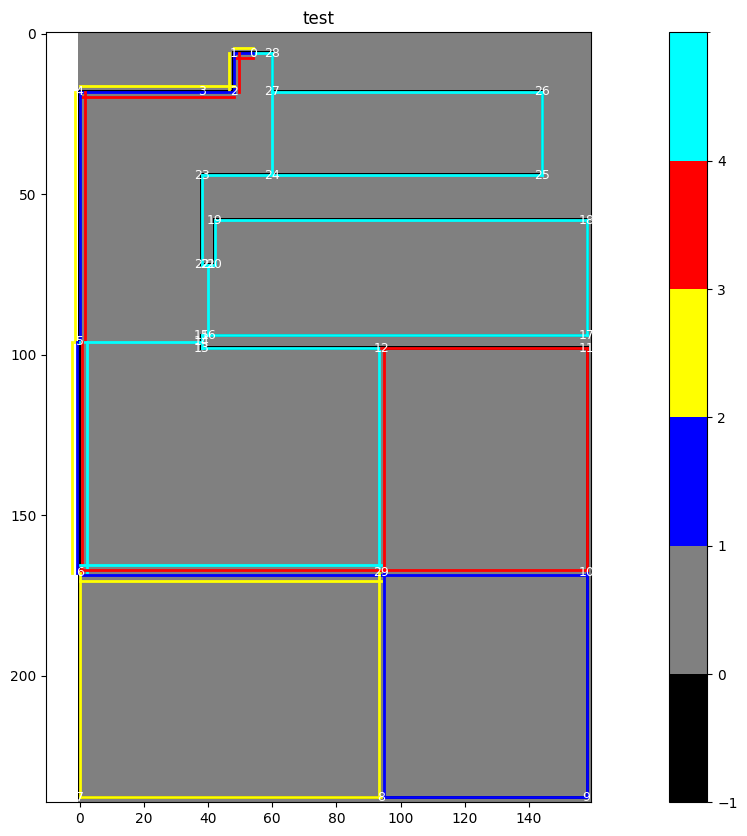

[47, 54, 41]
--- point 0 ---
{29: [29], 41: [41], 47: [47], 54: [54]}
--- point 1 ---
{41: [40, 41], 47: [46, 47], 54: [53, 54]}
--- point 2 ---
{39: [39, 40], 46: [45, 46], 53: [52, 53]}
--- point 3 ---
{39: [38, 39], 45: [44, 45], 52: [51, 52]}
--- point 4 ---
{38: [37, 38], 44: [43, 44], 51: [50, 51]}
--- point 5 ---
{14: [13, 14], 37: [36, 37], 43: [42, 43], 50: [49, 50]}
--- point 6 ---
{15: [14, 15], 42: [25, 26, 42], 36: [35, 36], 49: [48, 49]}
--- point 7 ---
{27: [26, 27]}
--- point 8 ---
{23: [22, 23], 24: [27, 24]}
--- point 9 ---
{20: [23, 20]}
--- point 10 ---
{16: [19, 16], 21: [20, 21]}
--- point 11 ---
{17: [16, 17]}
--- point 12 ---
{11: [10, 11], 18: [17, 18]}
--- point 13 ---
{12: [11, 12]}
--- point 14 ---
{13: [12, 13, 33]}
--- point 15 ---
{34: [33, 34]}
--- point 16 ---
{34: [9, 4, 34]}
--- point 17 ---
{5: [4, 5]}
--- point 18 ---
{6: [5, 6]}
--- point 19 ---
{7: [6, 7]}
--- point 20 ---
{8: [7, 8]}
--- point 21 ---
{30: [8, 9, 30]}
--- point 22 ---
{31: [30, 31

In [9]:
StateT = Tuple[int, int, int]
TransferT = Dict[StateT, List[Tuple[StateT, float]]]

def get_djk_states_for_color_at_pt(pt_to, color, pt, edge_pipes: Dict[Tuple[int, int], EdgePipes], pipe_color) -> List[StateT]:
    """
    保证逆时针给出
    """
    # from -pi to pi
    # 同色: i 直接对应管道在 EdgePipes 上的编号（存这个编号是为了方便插入）
    # 异色或边缘: i 对应 i 和 i - 1 之间的管道，将新成为 i
    states = []
    for y in pt_to[pt]:
        # pt -> y 方向的逆时针
        eid = edge_id((pt, y))
        ccw_pipes = edge_pipes[eid].ccw_pipes
        # i: color 相同或位于 0 号位置或左边为异色
        # 最右边且左边为异色
        i2 = []
        for i in list(range(len(edge_pipes[eid].ccw_pipes) + 1)):
            if i == 0:
                i2.append(i)
                continue
            if i == len(ccw_pipes):
                if pipe_color[ccw_pipes[i - 1]] != color:
                    i2.append(i)
                continue
            if pipe_color[ccw_pipes[i]] == color or pipe_color[ccw_pipes[i - 1]] != color:
                i2.append(i)
        if pt > y:
            i2 = list(reversed(i2))
        for i in i2:
            states.append((pt, y, i))
    return states

def test_get_djk_states_for_color_at_pt():
    # 随便构建一张图
    pt_to = [[1], [3, 0, 2, 4], [1], [1], [1]]
    edge_pipes = {
        (0, 1): EdgePipes([8, 7]),
        (1, 2): EdgePipes([1, 2, 3, 0]),
        (1, 3): EdgePipes([6, 4, 5]),
        (1, 4): EdgePipes(),
    }
    pipe_color = [6, 7, 6, 1, 7, 6, 6, 7, 1]
    states = get_djk_states_for_color_at_pt(pt_to, 1, 1, edge_pipes, pipe_color)
    # print(states)
    states = get_djk_states_for_color_at_pt(pt_to, 1, 2, edge_pipes, pipe_color)
    # print(states)
    assert(tuple(states)== tuple([(2, 1, 4), (2, 1, 2), (2, 1, 1), (2, 1, 0)]))
    # 输出 [(2, 1, 4)]? 表示一个在 2 点上，指向 1 的边上，在 (1, 2) 边的第 4 个管道L位置上

test_get_djk_states_for_color_at_pt()


def test_get_djk_states_for_color_at_pt2():
    # 随便构建一张图
    pt_to = [[1], [3, 0, 2, 4], [1], [1], [1]]
    edge_pipes = {
        (0, 1): EdgePipes([8, 7]),
        (1, 2): EdgePipes([1, 2, 3, 0]),
        (1, 3): EdgePipes([6, 4, 5]),
        (1, 4): EdgePipes(),
    }
    pipe_color = [6, 7, 6, 1, 7, 6, 6, 7, 1]
    state_set = set()
    for pt in range(5):
        states = get_djk_states_for_color_at_pt(pt_to, 1, pt, edge_pipes, pipe_color)
        for state in states:
            state_set.add(state)
    for st in state_set:
        pt, y, i = st
        assert((y, pt, i) in state_set)

test_get_djk_states_for_color_at_pt2()

def get_djk_transfer_for_color(pt_to, region_color, edge_pipes, pipe_color, seg_pts, pt_pipe_sets) -> TransferT:
    transfer: TransferT = dict()
    # List as Dict
    ccw_djk_states_of_pt = [get_djk_states_for_color_at_pt(pt_to, region_color, pt, edge_pipes, pipe_color) for pt in range(len(seg_pts))]
    # print(f'{edge_pipes[(2, 3)].ccw_pipes}, {edge_pipes[(4, 5)].ccw_pipes}')
    for pt in range(len(seg_pts)):
        djk_states: List[StateT] = ccw_djk_states_of_pt[pt]
        for s in djk_states:
            transfer[s] = []
            inv = (s[1], s[0], s[2])
            # check color
            ccw_pipe_li = edge_pipes[edge_id((s[0], s[1]))].ccw_pipes
            if s[2] < len(ccw_pipe_li) and region_color == pipe_color[ccw_pipe_li[s[2]]]:
                transfer[s].append((inv, 0))
            else:
                transfer[s].append((inv, pt_dis(seg_pts[s[0]], seg_pts[s[1]])))

        # 遍历任何一个状态为 [[set1_id(祖先), set1_cnt], [set2_id, set2_cnt], ...]
        # 
        # 更新 cnt 方式: 根据 edge pipe idx 找到对应的 pipe id
        pipe_sets_di = pt_pipe_sets[pt].get_sets_di()
        ancestor_di = pt_pipe_sets[pt].get_ancestor_di()
        # 记录祖先对应集合的元素的出现次数
        cnt_di = { x: 0 for x in pipe_sets_di.keys() if pipe_color[x] != region_color }
        def key(di):
            """
            传入 cnt_di，转换为键（忽略同色即若 pipe_color[k] == color 则不采纳键值对）
            &pipe_color
            """
            # return tuple(sorted(di.items()))
            return tuple(sorted([x for x in di.items() if pipe_color[x[0]] != region_color]))
        def go_through(x, y, st, ed):
            """
            &mut: cnt_di
            &ancestor_di
            &cnt_state_sets
            &edge_pipes
            &region_color
            &pipe_color

            方案 10L -> 方案 8L ，路过了 9, 8
            方案 0L -> 方案 2L: 路了 0, 1
            接同色 / 生长本颜色
            """
            eid = edge_id((x, y))
            pipes = edge_pipes[eid].ccw_pipes
            st, ed = np.clip(st, 0, len(pipes)), np.clip(ed, 0, len(pipes))
            def ccw_cross_i(i):
                pipe_id = pipes[i]
                if pipe_color[pipe_id] == region_color:
                    return
                sz = len(pipe_sets_di[ancestor_di[pipe_id]])
                cnt_di[ancestor_di[pipe_id]] += 1
                cnt_di[ancestor_di[pipe_id]] %= sz
            # [NOTE] 这里其实不用判断方向
            if st < ed:
                for i in range(st, ed):
                    # 越过 i 号现存管道，统计 cnt 变化
                    ccw_cross_i(i)
            else:
                for i in range(st - 1, ed - 1, -1):
                    ccw_cross_i(i)
                    
        ls = djk_states[0]
        cnt_state_sets: Dict[Tuple, Set[StateT]] = { key(cnt_di): { ls } }
        for s in djk_states[1:]:
            # 更新 cnt_di
            if s[1] == ls[1]:
                # 内部判断走向
                go_through(ls[0], ls[1], ls[2], s[2])
            else:
                # 不是同一个边内的，这里得判断走向
                if ls[0] < ls[1]:
                    go_through(ls[0], ls[1], ls[2], +INF)
                else:
                    go_through(ls[0], ls[1], ls[2], -INF)
                if s[0] < s[1]:
                    go_through(s[0], s[1], -INF, s[2])
                else:
                    go_through(s[0], s[1], +INF, s[2])
            k = key(cnt_di)
            if k not in cnt_state_sets:
                cnt_state_sets[k] = set()
            cnt_state_sets[k].add(s)
            ls = s # 不用 copy
        
        assert(np.all([v == 0 for v in cnt_di.values()]))
        # 一个 key 的所有状态可以互相到达
        for _, v in cnt_state_sets.items():
            for s in v:
                for ss in v:
                    if s != ss:
                        transfer[s].append((ss, 0))

    return ccw_djk_states_of_pt, transfer

def test_transfer():
    pt_to = [[1], [3, 0, 2, 4], [1], [1], [1]]
    edge_pipes = {
        (0, 1): EdgePipes([8, 7]),
        (1, 2): EdgePipes([0, 1, 2, 3]),
        (1, 3): EdgePipes([6, 4, 5]),
        (1, 4): EdgePipes(),
    }
    pipe_color = [1, 7, 6, 6, 6, 7, 6, 7, 1]
    seg_pts = [(3, 0), (1, 1), (2, 4), (-1, -1), (0, 4)]
    pt_pipe_sets = { x: DisjointSet() for x in range(len(seg_pts)) }
    pt_pipe_sets[0].add(7, 8)

    pt_pipe_sets[1].add(*range(9))
    pt_pipe_sets[1].mix(3, 6)
    pt_pipe_sets[1].mix(2, 4)
    pt_pipe_sets[1].mix(1, 5)
    pt_pipe_sets[1].mix(1, 7)
    pt_pipe_sets[1].mix(0, 8)

    pt_pipe_sets[2].add(0, 1, 2, 3)
    pt_pipe_sets[3].add(4, 5, 6)

    _, transfer = get_djk_transfer_for_color(pt_to, 7, edge_pipes, pipe_color, seg_pts, pt_pipe_sets)
    for k, v in transfer.items():
        print(k)
        for vv in v:
            print(' ' * 4, vv)

# test_transfer()

# color 不为零的进行考虑边上 pipes 的反向 Dijkstra
def dijk2(seg_pts, pt_to, cac_regions, destination_pt, cac_regions_dis):
    """
    order:
    - 原点相关
    - 边
    - 仙人掌图相关
    
    [约定]
    - 每条边的正方向：小点 -> 大点
    - 新状态位置: 0 (0) 1 (1) 2

    - 终点为根区域边
    - 同色边代价为 0. (dijkstra 为新增边最短)
    - 如何表示 djk 状态？
        - 点，边，管道
        - 同色：直接对应 i 管道
        - 连续两个异色 / 边缘异色：挤到原 i （右边） 和 i - 1 之间
    - 初始化 edge_state. edge_state 用 CacEdge 完全表示
        - 区域边缘加管道（逆时针遍历自己，插左边）
    - 每个区域寻路：建新图
        - state
            - pt, y, pipenum
            - (edge_state, color) -> state?
                 - pipe: get_pipes
                 - x, y, i (and y, x, i)
        - transfer
    """
    djk_order = np.argsort(cac_regions_dis)
    edge_pipes: Dict[Tuple[int, int], EdgePipes]= dict()
    for r in cac_regions:
        for x, y in zip(r.ccw_pts_id, r.ccw_pts_id[1:] + [r.ccw_pts_id[0]]):
            if edge_id((x, y)) not in edge_pipes:
                edge_pipes[edge_id((x, y))] = EdgePipes()

    # 每个 Disjoint Set 存储管道线段的 id 的集合
    pt_pipe_sets: Dict[int, DisjointSet] = { x: DisjointSet() for x in range(len(seg_pts)) }
    pipe_color = list() # start from 0. 实际上是 pipe segments
    region_start_pipes = [[] for _ in range(len(cac_regions))]
    # 每个有色区域逆时针一周添加管道。相邻的添加的管道在一个 pt_pipe_seg 中
    for i, r in enumerate(cac_regions):
        if r.color == 0:
            continue
        pipes_added = []
        for x, y in zip(r.ccw_pts_id, r.ccw_pts_id[1:] + [r.ccw_pts_id[0]]):
            """
            x -> y 加一条边
            """
            pipe_color.append(r.color)
            pipe_id = len(pipe_color) - 1
            pipes_added.append(pipe_id)
            # x -> y 可能是 3 -> 2，那也是 3 -> 2 方向的最左边插入
            # 即 x <- y 的最右边
            # ex: 2 -> 3, [2 <- 1 <- 0] 从右往左存
            # insert 2 -> 3 最左边? false, 0 | 内部 (idx - 0)
            edge_pipes[edge_id((x, y))].insert_pipe(x > y, 0, pipe_id)
            region_start_pipes[i].append(pipe_id)
        
        for x, pre_pipe, nxt_pipe in zip(r.ccw_pts_id, pipes_added[-1:] + pipes_added[:-1], pipes_added):
            pt_pipe_sets[x].add(pre_pipe)
            pt_pipe_sets[x].add(nxt_pipe)
            pt_pipe_sets[x].mix(pre_pipe, nxt_pipe)

    def state_attach_region(s, region_id):
        pipes = edge_pipes[edge_id((s[0], s[1]))].ccw_pipes
        return s[2] < len(pipes) and pipes[s[2]] in region_start_pipes[region_id]
    for region_ord in djk_order:
        print(f'--- {region_ord} ---')
        region_color = cac_regions[region_ord].color
        if region_color == 0:
            continue
        djk_states_pt, transfer = get_djk_transfer_for_color(pt_to, region_color, edge_pipes, pipe_color, seg_pts, pt_pipe_sets)
        dis = {}
        # Father state
        fa_s = {}
        for pt in range(len(seg_pts)):
            for s in djk_states_pt[pt]:
                dis[s] = INF
                fa_s[s] = (-1, -1, -1)
        q = PriorityQueue()
        for pt in range(len(seg_pts)):
            for s in djk_states_pt[pt]:
                if state_attach_region(s, region_ord):
                    q.put((0, s))
                    dis[s] = 0
        while not q.empty():
            _, s = q.get()
            # 终点不用继续搜
            if s[0] != destination_pt:
                for t, d in transfer[s]:
                    if dis[t] > dis[s] + d:
                        dis[t] = dis[s] + d
                        fa_s[t] = s
                        q.put((dis[t], t))
        attached_dest = []
        for k, v in dis.items():
            if k[0] == destination_pt:
                attached_dest.append((k, v))
        back_s = attached_dest[np.argmin([v for k, v in attached_dest])][0]
        assert(dis[back_s] < INF) # 有解
        s_chain = [back_s]
        while not state_attach_region(back_s, region_ord):
            back_s = fa_s[back_s]
            s_chain.append(back_s)
        s_chain.reverse()

        # 在原 edge_pipes 上添加加异色的交换边

        pipe_path_at_pt = { x: set() for x in range(len(seg_pts)) }
        # 起始边加入 path set
        pipe_path_at_pt[s_chain[0][0]].add(
            edge_pipes[edge_id((s_chain[0][0], s_chain[0][1]))].ccw_pipes[s_chain[0][2]]
        )
        for s, ns in zip(s_chain[:-1], s_chain[1:]):
            if not ((s[0], s[1]) == (ns[1], ns[0])):
                assert(s[0] == ns[0] and s[1] != ns[1])
                continue
            # 以下部分假设走了一条边
            eid = edge_id((s[0], s[1]))
            pipes = edge_pipes[eid].ccw_pipes
            in_fact_same_color = s[2] < len(pipes) and pipe_color[pipes[s[2]]] == region_color
            if not in_fact_same_color:
                pipe_color.append(region_color)
                pipe_id = len(pipe_color) - 1
                edge_pipes[eid].insert_pipe(True, s[2], pipe_id)
                pt_pipe_sets[s[0]].add(pipe_id)
                pt_pipe_sets[s[1]].add(pipe_id)

                pipe_path_at_pt[s[0]].add(pipe_id)
                pipe_path_at_pt[s[1]].add(pipe_id)
                print(f'insert {s[0]} -> {s[1]} at {s[2]}, color {region_color} pipe_id {pipe_id}')
            else:
                pipe_id = pipes[s[2]]
                pipe_path_at_pt[s[0]].add(pipe_id)
                pipe_path_at_pt[s[1]].add(pipe_id)
                
        for pt in range(len(seg_pts)):
            pipes = pipe_path_at_pt[pt]
            if len(pipes) >= 2:
                assert(len(pipes) == 2)
                pt_pipe_sets[pt].mix(*pipes)
                print(f'mix {pt} {pipes}')

    def test_plot_transfer():
        def plot_transfer(transfer, seg_pts):
            for s, li in transfer.items():
                for t in li:
                    st = s[0]
                    ed = t[0][0]
                    d = t[1]
                    if st == ed:
                        print(s, t)
                        continue
                    start_pt = seg_pts[st]
                    end_pt = seg_pts[ed]
                    plt.arrow(start_pt[1], start_pt[0], end_pt[1] - start_pt[1], end_pt[0] - start_pt[0],
                            head_width=1, head_length=2, fc='red', ec='red')
                    mid_x = (start_pt[0] + end_pt[0]) / 2
                    mid_y = (start_pt[1] + end_pt[1]) / 2
                    plt.text(mid_y, mid_x, f'{d:.1f}', color='blue', fontsize=8, ha='center', va='center')

        plt.figure(figsize=(20, 10))
        plot_matrix(GLOBAL_MAT, title='test')
        plot_num(SEG_PTS)
        plot_transfer(transfer, SEG_PTS)
        plt.show()

    def test_plot_pipes():
        def plot_pipes(edge_pipes, seg_pts, pipe_color, cmap):
            for (x, y), edge in edge_pipes.items():
                st, ed = seg_pts[x], seg_pts[y]
                def normalized(v):
                    return v / np.linalg.norm(v)
                dir = normalized(ed - st)
                dir_left = np.array([-dir[1], dir[0]])
                oy, ox = dir_left * 1.6

                sti = -len(edge.ccw_pipes) / 2 + 0.5
                for idx, pipe_id in enumerate(edge.ccw_pipes):
                    color = cmap[pipe_color[pipe_id]]
                    i = idx + sti 
                    plt.plot([st[1] + i * ox, ed[1] + i * ox],
                            [st[0] + i * oy, ed[0] + i * oy],
                            color=color, linewidth=2)
        # [pt sets]             
        # print('--- pt sets ---')
        # for k, v in pt_pipe_sets.items():
        #     print(f'{k}:')
        #     print(v.get_sets_di())

        plt.figure(figsize=(20, 10))
        plot_matrix(GLOBAL_MAT, title='test')
        plot_num(SEG_PTS)
        plot_pipes(edge_pipes, SEG_PTS, pipe_color, CMAP)
        plt.show()

    test_plot_pipes()
    return edge_pipes, pt_pipe_sets, pipe_color

EDGE_PIPES, PT_PIPE_SETS, PIPE_COLOR = dijk2(SEG_PTS, PT_EDGE_TO, CAC_REGIONS_FAKE, DESTINATION_PT, CAC_REGIONS_DIS)
print(EDGE_PIPES[(0, 1)].ccw_pipes)
for k, v in PT_PIPE_SETS.items():
    print(f'--- point {k} ---')
    print(v.get_sets_di())

- 点分，边拆
- 每个并查集选一个中心点 (x, y)

[PipeOnAxis(id=30, x=1.0, rw=1.0, lw=1.0)]
[PipeOnAxis(id=31, x=4.5, rw=4.5, lw=4.5)]
[PipeOnAxis(id=9, x=0, rw=0.6666666666666666, lw=0.6666666666666666)]


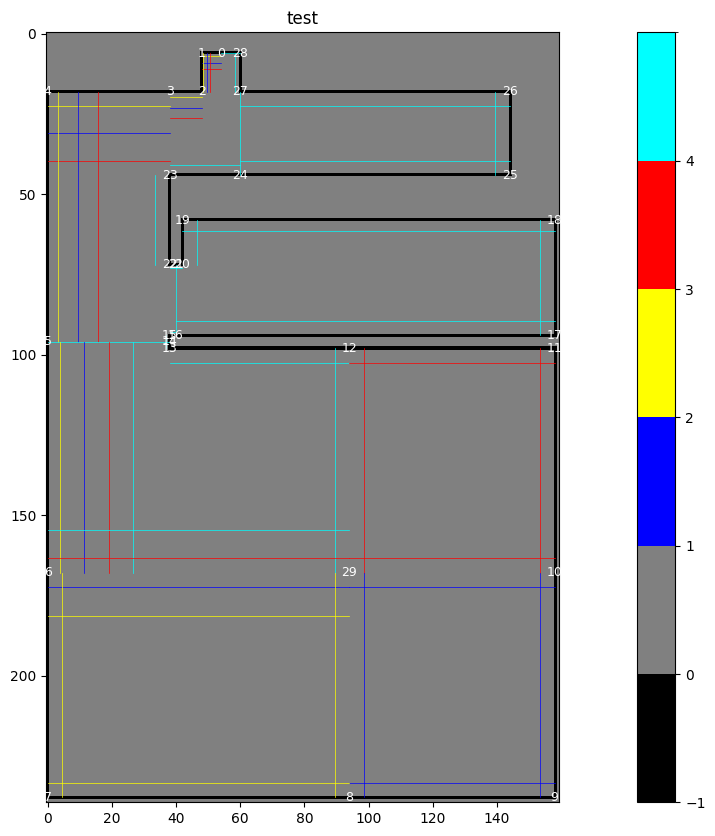

In [10]:
# def poly_edge_pipe_width_v1(poly: Polygon, edge_pipe_num: List[float], sug_w: float):
# 检查所有 region。如果边为墙边，则 num = len，否则 len / 2
import plane
import importlib
importlib.reload(plane)
from plane import Polygon, Point, poly_edge_pipe_width_v1, PipeOnAxis
"""
@dataclass
class PipeOnAxis:
    id: int
    x: float
    rw: float  # 右边宽度
    lw: float


def pt_edge_pipes_generate_pts_v1(
    center: Point, edge_pipes: List[List[PipeOnAxis]], edge_dir: List[Vec]
) -> Dict[int, Point]:
"""
# 约定是墙必须由连续的开始组成
def edge_is_wall(eid, seg_wall_pt_num):
    assert eid[0] < eid[1]
    def nxt(x):
        return (x + 1) % seg_wall_pt_num
    return eid[0] < seg_wall_pt_num and eid[1] < seg_wall_pt_num and nxt(eid[0]) == eid[1]

def get_xw_for_each_pipe(regions, seg_pts, seg_wall_pt_num, edge_pipes, sug_w):
    pipe_xw: Dict[int, PipeOnAxis] = dict()
    for cac in regions:
        for pti, nxt in zip(cac.ccw_pts_id, cac.ccw_pts_id[1:] + [cac.ccw_pts_id[0]]):
            for pipe_id in edge_pipes[edge_id((pti, nxt))].ccw_pipes:
                if pipe_id not in pipe_xw:
                    pipe_xw[pipe_id] = PipeOnAxis(pipe_id, 0, 0, 0)
    # fill this

    
    for cac in regions:
        pts: Polygon = [seg_pts[i] for i in cac.ccw_pts_id]
        n = len(pts)
        edge_pipe_num = []
        for pti, nxt in zip(cac.ccw_pts_id, cac.ccw_pts_id[1:] + [cac.ccw_pts_id[0]]):
            eid = edge_id((pti, nxt))
            if edge_is_wall(eid, seg_wall_pt_num):
                edge_pipe_num.append(len(edge_pipes[eid].ccw_pipes))
            else:
                edge_pipe_num.append(len(edge_pipes[eid].ccw_pipes) / 2.0)
        edge_pipe_width = poly_edge_pipe_width_v1(pts, edge_pipe_num, sug_w)

        # 更新所谓 xw
        def dir_range(x, y, dir):
            if x > y:
                return range(0)
            if dir > 0:
                return range(x, y + dir, dir)
            return range(y, x + dir, dir)
        def dir_range2(x, y, mid, dir):
            if x > y:
                return range(0)
            if dir > 0:
                return range(mid, y + dir, dir)
            return range(mid, x + dir, dir)
        for e_idx_in_region, (pti, nxt) in enumerate(zip(cac.ccw_pts_id, cac.ccw_pts_id[1:] + [cac.ccw_pts_id[0]])):
            eid = edge_id((pti, nxt))
            m = len(edge_pipes[eid].ccw_pipes)
            half_w = edge_pipe_width[e_idx_in_region] / 2.0
            x, y, mid, dir = 0, m - 1, (m - 1) / 2, (1 if pti < nxt else -1)
            def range_update(r: range, last: float):
                for idx in r:
                    pipe_id = edge_pipes[eid].ccw_pipes[idx]
                    pipe_xw[pipe_id].rw = half_w
                    pipe_xw[pipe_id].lw = half_w
                    pipe_xw[pipe_id].x = last + half_w * dir
                    last = pipe_xw[pipe_id].x + half_w * dir

                
            if edge_is_wall(eid, seg_wall_pt_num):
                range_update(dir_range(x, y, dir), 0)
            else:
                # 填一半。朝向当前 region 内部的方向
                if m % 2 == 0:
                    range_update(dir_range2(x, y, int(np.round(mid + 0.5 * dir)), dir), 0)
                else:
                    int_mid = int(np.round(mid))
                    if pti < nxt:
                        pipe_xw[edge_pipes[eid].ccw_pipes[int_mid]].rw = half_w
                    else:
                        pipe_xw[edge_pipes[eid].ccw_pipes[int_mid]].lw = half_w
                    pipe_xw[edge_pipes[eid].ccw_pipes[int_mid]].x = 0
                    range_update(dir_range2(x, y, int(np.round(mid + dir)), dir), half_w)
    
    return pipe_xw

PIPE_XW = get_xw_for_each_pipe(
    CAC_REGIONS_FAKE,
    SEG_PTS,
    SEG_WALL_PT_NUM,
    EDGE_PIPES,
    G0_PIPE_WIDTH
)


def test_plot_pipes():
    def plot_pipes(edge_pipes, seg_pts, pipe_color, cmap, pipe_xw):
        for (x, y), edge in edge_pipes.items():
            st, ed = seg_pts[x], seg_pts[y]
            def normalized(v):
                return v / np.linalg.norm(v)
            dir = normalized(ed - st)
            dir_left = np.array([-dir[1], dir[0]]) # x 正方向

            for idx, pipe_id in enumerate(edge.ccw_pipes):
                color = cmap[pipe_color[pipe_id]]
                x = pipe_xw[pipe_id].x
                so_st = st + dir_left * x
                so_ed = ed + dir_left * x
                plt.plot([so_st[1], so_ed[1]],
                        [so_st[0], so_ed[0]],
                        color=color, linewidth=0.5)
    # [pt sets]             
    # print('--- pt sets ---')
    # for k, v in pt_pipe_sets.items():
    #     print(f'{k}:')
    #     print(v.get_sets_di())

    plt.figure(figsize=(20, 10))
    plot_matrix(GLOBAL_MAT, title='test')
    plot_num(SEG_PTS)
    plot_pipes(EDGE_PIPES, SEG_PTS, PIPE_COLOR, CMAP, PIPE_XW)
    plt.show()

print([PIPE_XW[p] for p in EDGE_PIPES[(21, 22)].ccw_pipes])
print([PIPE_XW[p] for p in EDGE_PIPES[(22, 23)].ccw_pipes])
print([PIPE_XW[p] for p in EDGE_PIPES[(16, 21)].ccw_pipes])
test_plot_pipes()



20 {8: array([73., 41.]), 7: array([67.5, 46.5])}
[[PipeOnAxis(id=8, x=1.0, rw=1.0, lw=1.0)], [PipeOnAxis(id=7, x=-4.5, rw=4.5, lw=4.5)]]
[array([ 0., -1.]), array([-1.,  0.])]
21 {30: array([73., 39.]), 9: array([74., 40.]), 8: array([73., 41.])}
[[PipeOnAxis(id=30, x=1.0, rw=1.0, lw=1.0)], [PipeOnAxis(id=9, x=0, rw=0.6666666666666666, lw=0.6666666666666666)], [PipeOnAxis(id=8, x=-1.0, rw=1.0, lw=1.0)]]
[array([ 0., -1.]), array([1., 0.]), array([0., 1.])]
22 {30: array([73., 39.]), 31: array([67.5, 33.5])}
[[PipeOnAxis(id=30, x=-1.0, rw=1.0, lw=1.0)], [PipeOnAxis(id=31, x=4.5, rw=4.5, lw=4.5)]]
[array([0., 1.]), array([-1.,  0.])]
20: [72 42]
21: [72 40]
22: [72 38]


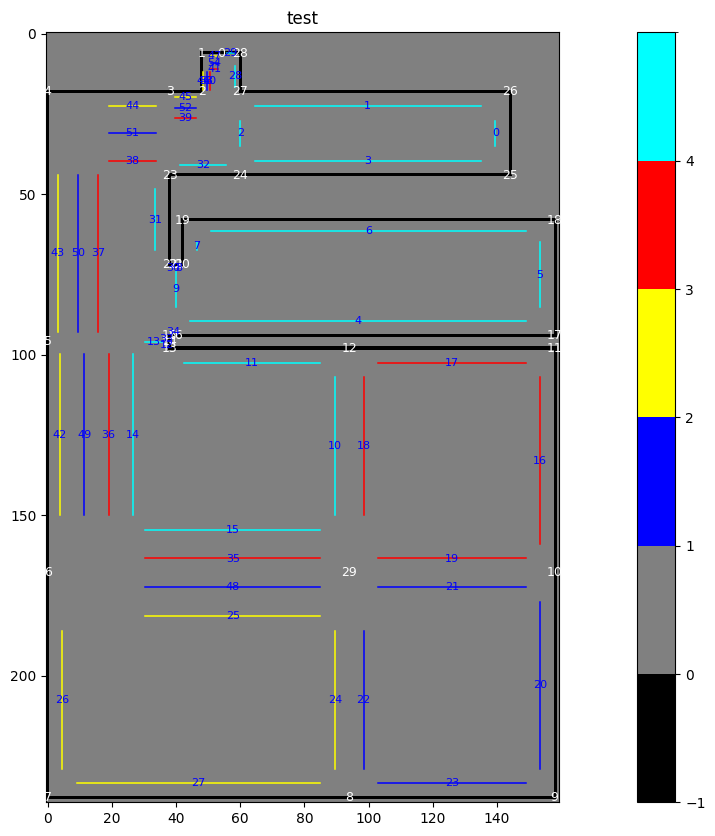

{(6, 18), (17, 12), (46, 2), (24, 8), (7, 19), (45, 3), (47, 0), (48, 29), (31, 22), (3, 24), (43, 5), (26, 7), (32, 23), (18, 12), (1, 26), (10, 29), (27, 8), (41, 1), (9, 21), (33, 15), (39, 3), (53, 2), (54, 1), (2, 27), (25, 29), (34, 16), (12, 13), (51, 4), (52, 3), (13, 5), (38, 4), (13, 14), (16, 10), (20, 10), (36, 6), (37, 5), (17, 11), (5, 18), (9, 16), (25, 6), (8, 20), (19, 29), (0, 25), (45, 2), (23, 8), (14, 5), (21, 29), (43, 4), (42, 6), (44, 3), (26, 6), (15, 6), (30, 22), (2, 24), (47, 1), (31, 23), (41, 0), (3, 25), (10, 12), (33, 14), (28, 27), (39, 2), (53, 1), (40, 1), (54, 0), (15, 29), (29, 28), (51, 3), (50, 5), (52, 2), (4, 17), (46, 1), (11, 13), (49, 6), (20, 9), (37, 4), (6, 19), (12, 14), (19, 10), (35, 6), (22, 8), (21, 10), (7, 20), (18, 29), (27, 7), (42, 5), (22, 29), (30, 21), (8, 21), (0, 26), (32, 24), (1, 27), (23, 9), (14, 6), (35, 29), (24, 29), (34, 15), (44, 4), (38, 3), (29, 0), (36, 5), (50, 4), (4, 16), (5, 17), (11, 12), (28, 28), (48, 6), 

In [11]:
import importlib
import plane
importlib.reload(plane)
from plane import pt_edge_pipes_expand_pts_v1, normalized

"""
def pt_edge_pipes_generate_pts_v1(
    center: Point, edge_pipes: List[List[PipeOnAxis]], edge_dir: List[Vec]
) -> Dict[int, Point]:
"""
G2Node = Tuple[int, int] # pipe_id, pt_id

def get_endpoint_for_each_pipe(seg_pts, pt_edge_to, edge_pipes, pipe_wx):
    # 初步生成
    node_set: Set[G2Node] = set()
    edge_dict: Dict[G2Node, List[G2Node]] = dict()
    node_pos: Dict[G2Node, Point] = dict()
    pipe_pt: Dict[int, List[int]] = dict()


    for uid in range(len(seg_pts)):
        center = seg_pts[uid]
        edge_dir = []
        u_edge_pipes = []
        for vid in pt_edge_to[uid]:
            eid = edge_id((uid, vid))
            edge_dir.append(normalized(seg_pts[vid] - center))
            pipe_id_li = edge_pipes[eid].get_pipes(uid < vid)
            wx_uv = [copy.deepcopy(pipe_wx[pid]) for pid in pipe_id_li]

            # [g2.step1]
            for pipe_id in pipe_id_li:
                node_set.add((pipe_id, uid))
                edge_dict[(pipe_id, uid)] = [(pipe_id, vid)]
            
            if uid > vid: 
                # 反转 x
                for wx in wx_uv:
                    wx.x = -wx.x
            u_edge_pipes.append(wx_uv)

        # 传入的所有 x 正方向为所属 edge_dir 方向的左方向
        expanded = pt_edge_pipes_expand_pts_v1(
            center,
            u_edge_pipes,
            edge_dir
        )
        if uid in [20, 21, 22]:
            print(uid, expanded)
            print(u_edge_pipes)
            print(edge_dir)
        for pipe_id, pos in expanded.items():
            if pipe_id not in pipe_pt:
                pipe_pt[pipe_id] = []
            pipe_pt[pipe_id].append(uid)
            node_pos[(pipe_id, uid)] = pos
    return pipe_pt, node_set, edge_dict, node_pos

PIPE_PT, NODE_SET_S1, EDGE_DICT_S1, NODE_POS_S1 = get_endpoint_for_each_pipe(SEG_PTS, PT_EDGE_TO, EDGE_PIPES, PIPE_XW)

for xx in [20, 21, 22]:
    print(f'{xx}: {SEG_PTS[xx]}')

def test_plot_pipes2():
    def plot_pipes(edge_pipes, seg_pts, pipe_color, cmap, pipe_pt, node_pos):
        for (x, y), edge in edge_pipes.items():
            st, ed = seg_pts[x], seg_pts[y]
            def normalized(v):
                return v / np.linalg.norm(v)

            for idx, pipe_id in enumerate(edge.ccw_pipes):
                color = cmap[pipe_color[pipe_id]]
                assert len(pipe_pt[pipe_id]) == 2
                pt0, pt1 = pipe_pt[pipe_id]
                st = node_pos[(pipe_id, pt0)]
                ed = node_pos[(pipe_id, pt1)]
                plt.plot([st[1], ed[1]],
                        [st[0], ed[0]],
                        color=color, linewidth=1.1)
                # 在中点绘制文字 pipe_id
                mid = (st + ed) / 2
                plt.text(mid[1], mid[0], f'{pipe_id}', color='blue', fontsize=8, ha='center', va='center')
    # [pt sets]             
    # print('--- pt sets ---')
    # for k, v in pt_pipe_sets.items():
    #     print(f'{k}:')
    #     print(v.get_sets_di())

    plt.figure(figsize=(20, 10))
    plot_matrix(GLOBAL_MAT, title='test')
    plot_num(SEG_PTS)
    plot_pipes(EDGE_PIPES, SEG_PTS, PIPE_COLOR, CMAP, PIPE_PT, NODE_POS_S1)
    plt.show()

test_plot_pipes2()
print(NODE_SET_S1)
for k, v in EDGE_DICT_S1.items():
    print(f"{k}: {v}")
    assert k in NODE_SET_S1
    assert all([x in NODE_SET_S1 for x in v])


{31: [30, 31]}
[73. 39.]


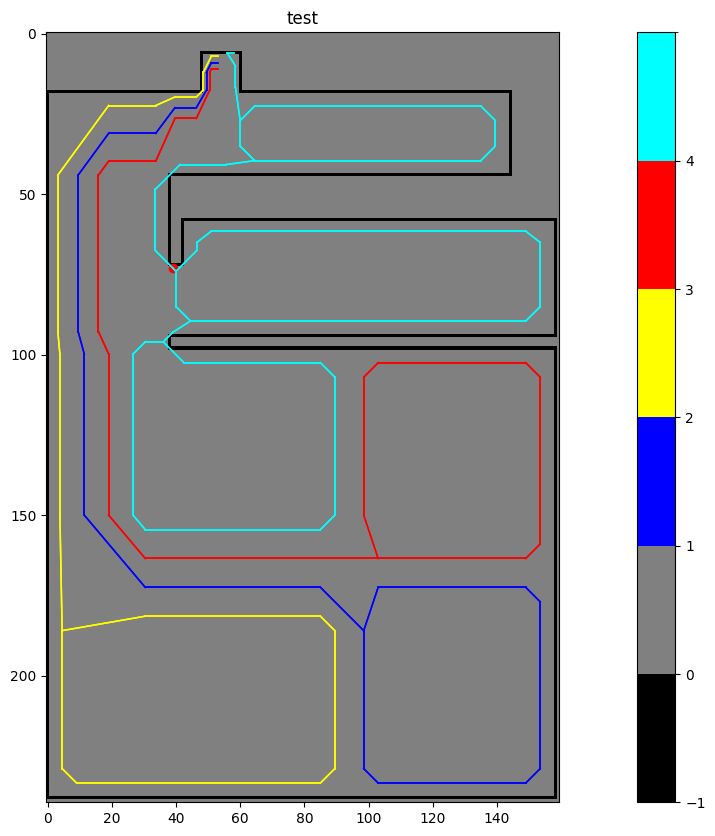

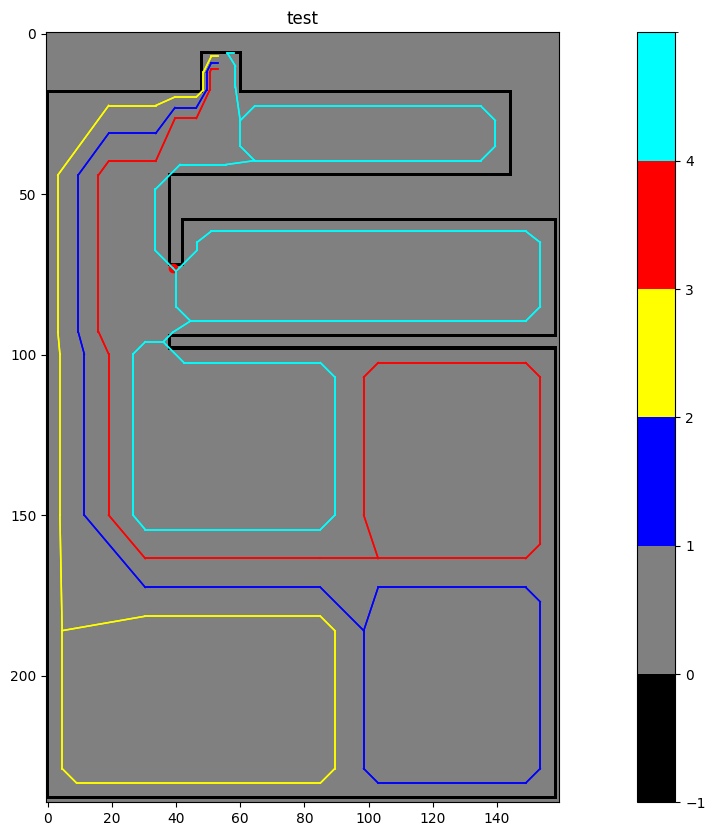

105 110


In [12]:
from plane import same_point
"""
最后搞成无环图即可
"""
def build_linked_g2(node_set, edge_dict, pt_pipe_sets) -> Tuple[Set[G2Node], Dict[G2Node, List[G2Node]]]:
    node_set = copy.deepcopy(node_set)
    edge_dict = copy.deepcopy(edge_dict)
    for pt_id in pt_pipe_sets.keys():
        for _, disjoint in pt_pipe_sets[pt_id].get_sets_di().items():
            for i in range(1, len(disjoint)):
                assert (disjoint[i], pt_id) in node_set
                edge_dict[(disjoint[i], pt_id)].append((disjoint[i - 1], pt_id))
                edge_dict[(disjoint[i - 1], pt_id)].append((disjoint[i], pt_id))


    return node_set, edge_dict

NODE_SET_S2, EDGE_DICT_S2 = build_linked_g2(NODE_SET_S1, EDGE_DICT_S1, PT_PIPE_SETS)
# print(NODE_SET_S2)
for k, v in EDGE_DICT_S2.items():
    # print(f"{k}: {v}")
    assert k in NODE_SET_S2
    assert all([x in NODE_SET_S2 for x in v])

def test_g2_s2():
    print(PT_PIPE_SETS[22].get_sets_di())
    print(NODE_POS_S1[(30, 22)])
    plt.figure(figsize=(20, 10))
    plot_matrix(GLOBAL_MAT, title='test')
    # plot_num(SEG_PTS)
    # plot all edge in EDGE_DICT_S2
    pos = NODE_POS_S1[(30, 22)]
    plt.plot([pos[1]], [pos[0]], 'o', color='red')
    
    for k, v in EDGE_DICT_S2.items():
        for vv in v:
            st = NODE_POS_S1[k]
            ed = NODE_POS_S1[vv]
            plt.plot([st[1], ed[1]],
                    [st[0], ed[0]],
                    color=CMAP[PIPE_COLOR[k[0]]], linewidth=1.1)
    plt.show()

test_g2_s2()

# 去重. 几乎重合的点合并，边关系也合并
def g2_unique_xy(node_set_s2, edge_dict_s2, node_pos_s2) -> Tuple[Set[G2Node], Dict[G2Node, List[G2Node]], Dict[G2Node, Point]]:
    node_set_s3: Set[G2Node] = set()
    edge_dict_s3: Dict[G2Node, List[G2Node]] = dict()
    node_pos_s3: Dict[G2Node, Point] = dict()
    map_s2_s3: Dict[G2Node, G2Node] = dict()
    for u_s2 in node_set_s2:
        for u_s3, pos in node_pos_s3.items():
            if same_point(node_pos_s2[u_s2], pos):
                map_s2_s3[u_s2] = u_s3
                break
            
        if u_s2 not in map_s2_s3:
            node_set_s3.add(u_s2)
            node_pos_s3[u_s2] = node_pos_s2[u_s2]
            map_s2_s3[u_s2] = u_s2

    # copy edges
    for u_s2 in node_set_s2:
        u_s3 = map_s2_s3[u_s2]
        for v_s2 in edge_dict_s2[u_s2]:
            v_s3 = map_s2_s3[v_s2]
            edge_dict_s3[u_s3] = edge_dict_s3.get(u_s3, []) + [v_s3]

    return node_set_s3, edge_dict_s3, node_pos_s3

G2_NODE_SET_S3, G2_EDGE_DICT_S3, G2_NODE_POS_S3 = g2_unique_xy(NODE_SET_S2, EDGE_DICT_S2, NODE_POS_S1)
    
def test_g2_s3():
    plt.figure(figsize=(20, 10))
    plot_matrix(GLOBAL_MAT, title='test')
    # plot_num(SEG_PTS)
    # plot all edge in EDGE_DICT_S2
    pos = G2_NODE_POS_S3[(30, 22)]
    plt.plot([pos[1]], [pos[0]], 'o', color='red')
    
    for k, v in G2_EDGE_DICT_S3.items():
        for vv in v:
            st = G2_NODE_POS_S3[k]
            ed = G2_NODE_POS_S3[vv]
            plt.plot([st[1], ed[1]],
                    [st[0], ed[0]],
                    color=CMAP[PIPE_COLOR[k[0]]], linewidth=1.1)
    plt.show()

test_g2_s3()
print(len(G2_NODE_SET_S3), len(NODE_SET_S2))

------
---
no_del_cycle: [(13, 14), (13, 5), (14, 5), (14, 6), (15, 6), (15, 29), (10, 29), (10, 12), (11, 12), (11, 13), (12, 13)]
pts_xy: [array([96., 36.]), array([96. , 30.4]), array([99.8, 26.6]), array([150. ,  26.6]), array([154.5,  30.4]), array([154.5,  85. ]), array([150. ,  89.5]), array([107. ,  89.5]), array([102.5,  85. ]), array([102.5,  42.5]), array([97., 37.])]
outer_cnt: 7
indices: [('outer', 0), ('outer', 1), ('outer', 2), ('outer', 3), ('outer', 4), ('outer', 5), ('outer', 6), ('inner', 6, 0), ('inner', 6, 1), ('inner', 6, 2), ('inner', 6, 3), ('inner', 6, 4), ('inner', 6, 5), ('inner', 6, 6), ('inner', 6, 7), ('inner', 6, 8), ('inner', 6, 9)]
---
no_del_cycle: [(13, 5), (14, 5), (14, 6), (15, 6), (15, 29), (10, 29), (10, 12), (11, 12), (11, 13), (12, 13), (13, 14)]
pts_xy: [array([96. , 30.4]), array([99.8, 26.6]), array([150. ,  26.6]), array([154.5,  30.4]), array([154.5,  85. ]), array([150. ,  89.5]), array([107. ,  89.5]), array([102.5,  85. ]), array([102.5,

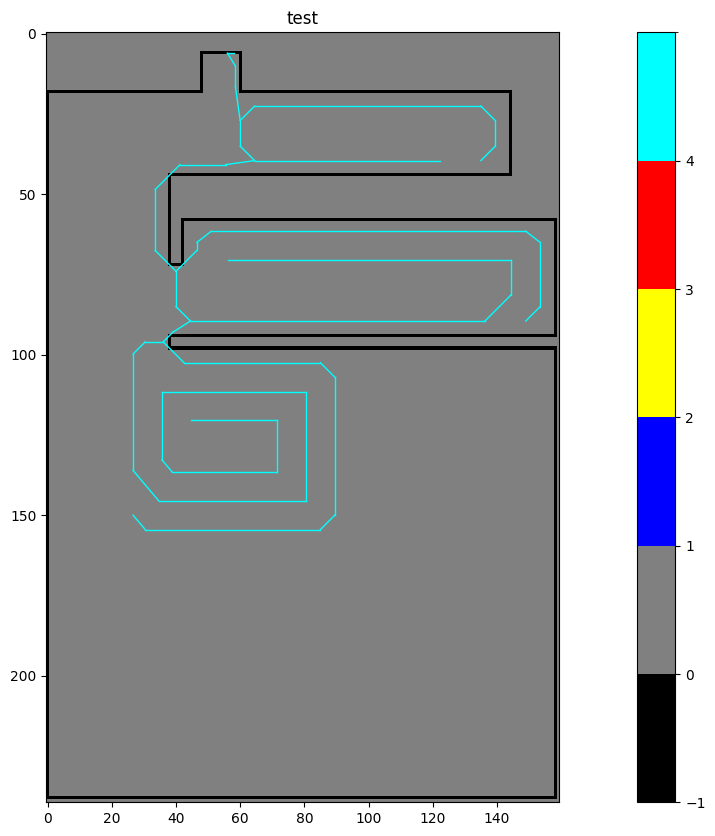

In [13]:
importlib.reload(plane)
from plane import inner_recursive_v2_api
"""
从 0 出发直接找环，若是环则直接圈 v1
"""
def g3_tarjan_for_a_color(start_node, node_set, edge_dict, node_pos, w_sug):
    """
    参数均为 G2
    """
    g3_node: Set = set()
    # 有向边
    g3_edge: Dict = dict() # copy.deepcopy(edge_dict)
    g3_node_pos: Dict[Hashable, Point] = dict()
    stack = []

    dfn = dict()
    low = dict()
    cnt = 0

    def tarjan(u, fa):
        nonlocal cnt # nonlocal stack value
        cnt += 1
        dfn[u] = low[u] = cnt
        stack.append(u)

        # [g3]
        g3_node.add(("outer", u))
        g3_node_pos[("outer", u)] = node_pos[u]


        def solve_g2_cycle(cycle: List[G2Node]):
            rt = cycle[0]
            # 由于保持内盘旋 w_sug 需要，尾部若干点可能被删除
            # [方法1]
            # 原点保持存在，并连接到当前外围最后一点
            # - 为何不投影
            #   - 会交叉
            # - 为何不放宽缺口处宽度要求
            #   - 首尾共线时宽度可能为 0
            # [方法2] [当前方案]
            # - 找到某一个起点使得不用删除 outer
            def fn():
                no_del_cycle = copy.deepcopy(cycle)
                print('------')
                for _ in range(len(cycle)):
                    print('---')
                    print(f'no_del_cycle: {no_del_cycle}')
                    pts_xy = [node_pos[x] for x in no_del_cycle]
                    # [NOTE] 性能问题
                    print(f'pts_xy: {pts_xy}')
                    inner_pts, indices = inner_recursive_v2_api(pts_xy, w_sug)
                    outer_cnt = sum([1 for x in indices if x[0] == "outer"])
                    print(f'outer_cnt: {outer_cnt}')
                    print(f'indices: {indices}')
                    if outer_cnt == len(no_del_cycle):
                        return no_del_cycle, inner_pts, indices
                    no_del_cycle = no_del_cycle[1:] + [no_del_cycle[0]]
                print(f'cycle: {cycle}')
                raise ValueError('Can\'t find any circle without outer deletion.')
            # inner_pts, indices = inner_recursive_v2_api(pts_xy, w_sug)
            no_del_cycle, inner_pts, indices = fn()
            print(f'no_del_cycle: {no_del_cycle}')
            print(f'inner_pts: {inner_pts}')
            print(f'indices: {indices}')

            rt_idx = no_del_cycle.index(rt)
            # [反向加 outer 边]
            for i in range(rt_idx, 0, -1):
                g3_id = ("outer", no_del_cycle[i])
                g3_edge[g3_id] = g3_edge.get(g3_id, []) + [("outer", no_del_cycle[i - 1])]
            # [正向加 outer 边]
            for i in range(rt_idx, len(no_del_cycle) - 1):
                g3_id = ("outer", no_del_cycle[i])
                g3_edge[g3_id] = g3_edge.get(g3_id, []) + [("outer", no_del_cycle[i + 1])]
            # [制作 inner 点和边]
            last = ("outer", no_del_cycle[-1])
            for idx, pt in enumerate(inner_pts[len(no_del_cycle):]):
                g3_id = ("inner", no_del_cycle[-1], idx)
                g3_node.add(g3_id)
                g3_edge[last] = g3_edge.get(last, []) + [g3_id]
                g3_node_pos[g3_id] = pt
                last = g3_id

        for v in edge_dict[u]:
            if v == fa:
                continue
            if v not in dfn:
                # [树边]
                # g3_edge[u] = g3_edge.get(u, []) + [v]
                tarjan(v, u)
                low[u] = min(low[u], low[v])
                if low[v] > dfn[u]:
                    assert stack[-1] == v
                    # 非环边
                    g3_uid = ("outer", u)
                    g3_edge[g3_uid] = g3_edge.get(g3_uid, []) + [("outer", v)]
                    stack.pop()
                elif low[v] == dfn[u]:
                    # 环首边，退栈求环
                    cycle = []
                    while stack[-1] != u:
                        cycle.append(stack.pop())
                    cycle.append(u) # 不 pop
                    cycle.reverse()
                    solve_g2_cycle(cycle)
            else:
                low[u] = min(low[u], dfn[v])

        """
        无向图二元环就是重边
        """

        """
        low[u] == dfn[u] 则 u 到栈顶是环，或 u 不在环中
        """
        # if low[u] == dfn[u]:
        #     if u == stack[-1]:
        #         stack.pop()
        #         return
        #     cycle: List[G2Node] = []
        #     while stack[-1] != u:
        #         cycle.append(stack.pop())
        #     cycle.append(stack.pop())
        #     cycle.reverse()
        #     # for i in range(len(cycle) - 1):
        #     #     g3_edge[cycle[i]].append(cycle[i + 1])
        #     print(f'cycle: {cycle}')
            
    tarjan(start_node, None)
    return g3_node, g3_edge, g3_node_pos
               
# check 0
def g2_get_start_nodes(g2_node_set):
    return [node for node in g2_node_set if node[1] == 0]

G2_START_NODES = g2_get_start_nodes(G2_NODE_SET_S3)

def test_g3_one_color():
    s = G2_START_NODES[3]
    n, e, p = g3_tarjan_for_a_color(
        s,
        G2_NODE_SET_S3,
        G2_EDGE_DICT_S3,
        G2_NODE_POS_S3,
        G0_PIPE_WIDTH
    )
    for k, v in p.items():
        print(f'{k}: {v}')
    print('--- e ---')
    for k, v in e.items():
        print(f'{k}: {v}')

    plt.figure(figsize=(20, 10))
    plot_matrix(GLOBAL_MAT, title='test')
    # plot_num(SEG_PTS)
    def dfs_plot(u):
        for v in e.get(u, []):
            plt.plot([p[u][1], p[v][1]], [p[u][0], p[v][0]], color=CMAP[PIPE_COLOR[s[0]]], linewidth=1)
            dfs_plot(v)

    dfs_plot(("outer", s))
    plt.show()

test_g3_one_color()

------
---
no_del_cycle: [(26, 6), (26, 7), (27, 7), (27, 8), (24, 8), (24, 29), (25, 29), (25, 6)]
pts_xy: [array([186. ,   4.5]), array([229. ,   4.5]), array([233.5,   9. ]), array([233.5,  85. ]), array([229. ,  89.5]), array([186. ,  89.5]), array([181.5,  85. ]), array([181.5,  30.4])]
outer_cnt: 8
indices: [('outer', 0), ('outer', 1), ('outer', 2), ('outer', 3), ('outer', 4), ('outer', 5), ('outer', 6), ('outer', 7), ('inner', 7, 0), ('inner', 7, 1), ('inner', 7, 2), ('inner', 7, 3), ('inner', 7, 4), ('inner', 7, 5), ('inner', 7, 6), ('inner', 7, 7), ('inner', 7, 8), ('inner', 7, 9)]
no_del_cycle: [(26, 6), (26, 7), (27, 7), (27, 8), (24, 8), (24, 29), (25, 29), (25, 6)]
inner_pts: [array([186. ,   4.5]), array([229. ,   4.5]), array([233.5,   9. ]), array([233.5,  85. ]), array([229. ,  89.5]), array([186. ,  89.5]), array([181.5,  85. ]), array([181.5,  30.4]), array([184.43629344,  13.5       ]), array([224.5,  13.5]), array([224.5,  80.5]), array([190.5,  80.5]), array([190.

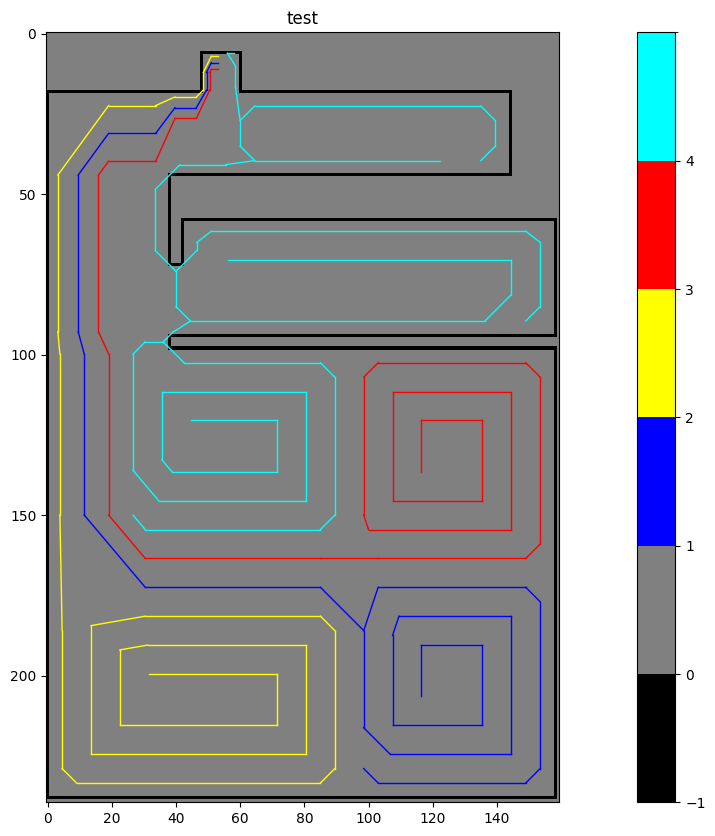

In [14]:
def test_g3_all_color():
    plt.figure(figsize=(20, 10))
    plot_matrix(GLOBAL_MAT, title='test')
    for s in G2_START_NODES:
        n, e, p = g3_tarjan_for_a_color(
            s,
            G2_NODE_SET_S3,
            G2_EDGE_DICT_S3,
            G2_NODE_POS_S3,
            G0_PIPE_WIDTH
        )

        # plot_num(SEG_PTS)
        def dfs_plot(u):
            for v in e.get(u, []):
                plt.plot([p[u][1], p[v][1]], [p[u][0], p[v][0]], color=CMAP[PIPE_COLOR[s[0]]], linewidth=1)
                dfs_plot(v)

        dfs_plot(("outer", s))
    plt.show()

test_g3_all_color()

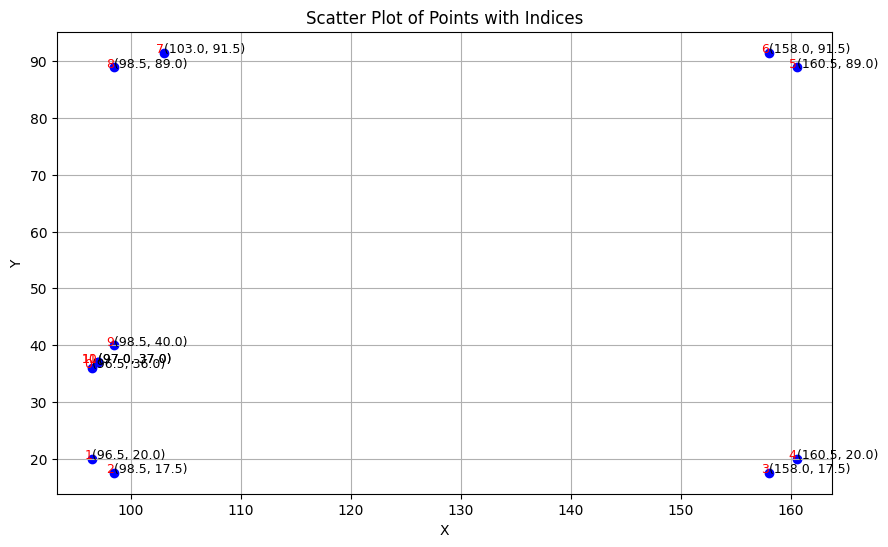

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_points_with_indices():
    pts_xy = [
    np.array([96.5, 36.]), np.array([96.5, 20.]), np.array([98.5, 17.5]),
    np.array([158., 17.5]), np.array([160.5, 20.]), np.array([160.5, 89.]),
    np.array([158., 91.5]), np.array([103., 91.5]), np.array([98.5, 89.]),
    np.array([98.5, 40.]), np.array([97., 37.]), np.array([97., 37.])
]
    # 提取 x 和 y 坐标
    x_coords = [pt[0] for pt in pts_xy]
    y_coords = [pt[1] for pt in pts_xy]

    # 绘制点
    plt.figure(figsize=(10, 6))
    plt.scatter(x_coords, y_coords, color='blue')

    # 添加点的标注和编号
    for i, (x, y) in enumerate(zip(x_coords, y_coords)):
        plt.text(x, y, f'{i}', fontsize=9, ha='right', color='red')
        plt.text(x, y, f'({x:.1f}, {y:.1f})', fontsize=9, ha='left')

    # 设置坐标轴标签和标题
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Scatter Plot of Points with Indices')

    # 显示图形
    plt.grid(True)
    plt.show()

# 示例用法

plot_points_with_indices()

In [16]:
"""
ok
"""


{2: [1, 2]}
{2: [1, 2], 3: [3], 4: [4]}
{2: [1, 2], 4: [3, 4], 5: [5]}
{1: 4, 2: 4, 3: 4, 4: 4, 5: 5}
